In [1]:
# imports
import time
from datetime import datetime
import pytz
from collections import deque

# library imports
import requests

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pacswg.timer import TimerClass

# config
my_timezone = os.getenv('PY_TZ', 'America/Toronto')

# small functions
def get_time_with_tz():
    return datetime.now().astimezone(pytz.timezone(my_timezone))

In [2]:
# configs
server_address = 'http://localhost:3000'
# service_name = 'tfserving-resnetv2'
service_name = 'bentoml-onnx-resnet50'
# service_name = 'bentoml-iris'
# service_name = 'tfserving-mobilenetv1'

# length of measurements used to estimate different batch size response times
upstream_rt_max_len = 100

# Getting and Setting Stats and Configs

In [13]:
def fetch_raw_server_proxy_stats():
    url = f'{server_address}/proxy-monitor/{service_name}'
    response = requests.get(url)
    response.raise_for_status()
    return response.json()

def get_proxy_stats():
    raw_stats = fetch_raw_server_proxy_stats()
    return {
        'maxBufferSize': raw_stats['maxBufferSize'],
        'averageMaxBufferSize': raw_stats['windowedHistoryValues']['maxBufferSize']['average'],
        'averageActualBatchSize': raw_stats['windowedUpstream']['batchSizes']['average'],
        'maxBufferTimeoutMs': raw_stats['maxBufferTimeoutMs'],
        'currentReplicaCount': raw_stats['currentMonitorStatus']['currentReplicaCount'],
        'currentReadyReplicaCount': raw_stats['currentMonitorStatus']['currentReplicaCount'],
        'currentConcurrency': raw_stats['currentMonitorStatus']['currentConcurrency'],
        'averageConcurrency': raw_stats['windowedHistoryValues']['concurrency']['average'],
        'averageArrivalRate': raw_stats['windowedHistoryValues']['arrival']['rate'],
        'averageDepartureRate': raw_stats['windowedHistoryValues']['departure']['rate'],
        'averageDispatchRate': raw_stats['windowedHistoryValues']['dispatch']['rate'],
        'averageErrorRate': raw_stats['windowedHistoryValues']['error']['rate'],
        'averageTimeoutRatio': raw_stats['windowedHistoryValues']['timeoutRatio']['average'],
        'reponseTimeAverage': raw_stats['responseTimes']['stats']['average'],
        'reponseTimeP50': raw_stats['responseTimes']['stats']['q50'],
        'reponseTimeP95': raw_stats['responseTimes']['stats']['q95'],
        'batchResponseTimeStats': raw_stats['windowedUpstream']['responseTimes'],
    }

def set_proxy_config(update_config):
    url = f'{server_address}/proxy-config/{service_name}'
    response = requests.post(url, json=update_config)
    response.raise_for_status()
    return response.json()


# display(fetch_raw_server_proxy_stats())
# display(get_proxy_stats())
# set_proxy_config({'maxBufferSize': 5})

In [4]:
proxy_stats = get_proxy_stats()
proxy_stats

{'maxBufferSize': 3,
 'averageMaxBufferSize': 3,
 'averageActualBatchSize': 2.9444444444444446,
 'maxBufferTimeoutMs': 1000,
 'currentReplicaCount': 2,
 'currentReadyReplicaCount': 2,
 'currentConcurrency': 3,
 'averageConcurrency': 3.6,
 'averageArrivalRate': 4.15,
 'averageDepartureRate': 4.4,
 'averageDispatchRate': 4.1,
 'averageErrorRate': 0,
 'averageTimeoutRatio': 0.07142857142857142,
 'reponseTimeAverage': 931.6490566037736,
 'reponseTimeP50': 940,
 'reponseTimeP95': 1639.5999999999997,
 'batchResponseTimeStats': {'2': {'values': [273, 578, 582, 644, 649],
   'stats': {'q50': 582, 'q95': 648, 'average': 545.2, 'count': 5},
   'batchSize': 2},
  '3': {'values': [391,
    400,
    402,
    403,
    405,
    407,
    408,
    409,
    416,
    418,
    422,
    422,
    424,
    428,
    429,
    436,
    443,
    444,
    445,
    447,
    448,
    449,
    449,
    450,
    450,
    451,
    452,
    452,
    454,
    457,
    458,
    459,
    460,
    460,
    461,
    462,
  

In [5]:
def update_batch_rt_values(batch_rt_values, proxy_stats):
    for batch_size_str in proxy_stats['batchResponseTimeStats']:
        batch_size = int(batch_size_str)
        if not(batch_size in batch_rt_values):
            batch_rt_values[batch_size] = deque(maxlen=upstream_rt_max_len)
        # concatenate arrays
        batch_rt_values[batch_size].extend(proxy_stats['batchResponseTimeStats'][batch_size_str]['values'])

    return batch_rt_values

batch_rt_values = {}
update_batch_rt_values(batch_rt_values, proxy_stats)

{2: deque([273, 578, 582, 644, 649]),
 3: deque([391,
        400,
        402,
        403,
        405,
        407,
        408,
        409,
        416,
        418,
        422,
        422,
        424,
        428,
        429,
        436,
        443,
        444,
        445,
        447,
        448,
        449,
        449,
        450,
        450,
        451,
        452,
        452,
        454,
        457,
        458,
        459,
        460,
        460,
        461,
        462,
        463,
        463,
        463,
        466,
        469,
        481,
        503,
        514,
        839,
        881,
        885,
        886,
        902,
        903,
        908,
        908,
        910,
        910,
        913,
        920,
        923,
        929,
        934,
        935,
        938,
        939,
        942,
        946,
        953,
        954,
        956,
        959,
        960,
        962,
        966,
        966,
        978,
        97

In [14]:
# run a loop to monitor response times to test the functionality
timer = TimerClass()

batch_rt_values = {}
for _ in range(6):
    proxy_stats = get_proxy_stats()
    update_batch_rt_values(batch_rt_values, proxy_stats)
    timer.tic()
    while timer.toc() < 10:
        time.sleep(1)


,batch_size,average_response_time
0,1,277.000000
1,2,625.045455
2,3,772.420000
3,4,1137.260000
4,5,1139.450000


(233.8775, 1182.5725)

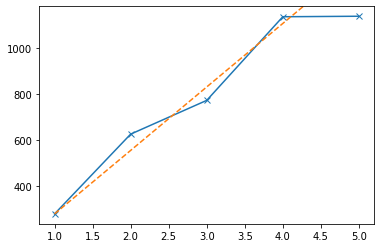

In [28]:
batch_size_results = []
for bs, vals in batch_rt_values.items():
    # print(bs, len(vals), np.mean(vals))
    batch_size_results.append({
        'batch_size': bs,
        'average_response_time': np.mean(vals),
    })

df_batch_size = pd.DataFrame(data=batch_size_results)
df_batch_size = df_batch_size.sort_values(by='batch_size')
display(df_batch_size)

plt.plot(df_batch_size['batch_size'], df_batch_size['average_response_time'], marker='x')
prev_ylim = plt.gca().get_ylim()
# relative average response time by batch size (linear scale)
relative_scaled_response_time = df_batch_size['batch_size']/df_batch_size['batch_size'].iloc[0]*df_batch_size['average_response_time'].iloc[0]
# plot the linear baseline
plt.plot(df_batch_size['batch_size'], relative_scaled_response_time, ls='--')
plt.ylim(prev_ylim)

# Create Control Algorithms

In [8]:
def calculate_new_bs(curr_bs, inc=True, config=None):
    if config is None:
        config = {
            'max_bs': 100,
            'min_bs': 20,
            'inc_step': 1,
            'dec_mult': 0.7,
        }

    if inc:
        new_bs = curr_bs + config['inc_step']
        # at least one step is made
        new_bs = max(new_bs, curr_bs+1)
    else:
        new_bs = curr_bs * config['dec_mult']
        # at least one step is made
        new_bs = min(new_bs, curr_bs-1)

    new_bs = min(new_bs, config['max_bs'])
    new_bs = max(new_bs, config['min_bs'])

    return new_bs

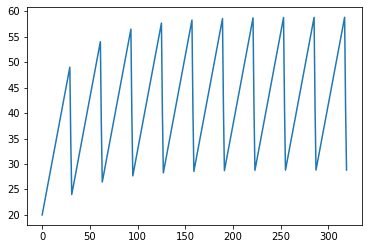

In [9]:
all_bs = []
curr_bs = 10
for _ in range(10):
    for _ in range(30):
        curr_bs = calculate_new_bs(curr_bs, True)
        all_bs.append(curr_bs)
    for _ in range(2):
        curr_bs = calculate_new_bs(curr_bs, False)
        all_bs.append(curr_bs)

plt.plot(all_bs)

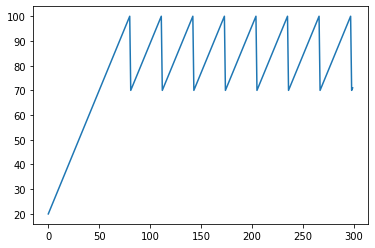

In [10]:
all_bs = []
curr_bs = 10
target = 90
for _ in range(300):
    if curr_bs > target * 1.1:
        curr_bs = calculate_new_bs(curr_bs, False)
    else:
        curr_bs = calculate_new_bs(curr_bs, True)

    all_bs.append(curr_bs)

plt.plot(all_bs)